### TEST GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [2,4], [8,6]]
sigmas_gt = [ np.matrix([[5, -2],[-2, 6]]), np.matrix([[5,-2],[-2,6]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.5, 0.5]

# Size of dataset

m = 400

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()
Z = np.array(Z)
y= Z
# y = Z + 1
# print(y)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        #pj is multivariate_normal.pdf in CP class
        pj = Gaussian(X, Mu[:,j], Sigma[j,:,:])
        pj_arr[0:m,j] = pj
        W[:,j] = Phi[j] * pj

    # W tells us what is the relative weight of each cluster for each data point
    #responsibilities
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    #take pj according to labels #probability of belonging to that particular label
    pj = pj_arr[np.arange(0,m,1),labels]
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label


In [4]:
K = 8

likelihoods = []
threshold = np.matrix(.01)

for k in range(2,K+1):
    print(k,end= "\t")
    likelihood = -float('inf')
    
    for attempt in range(10):
        Phi, Mu, Sigma = init_gmm(X, k)

        converged = False
        while not converged:
            converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

        l = np.mean(np.log(pj))
        if(l > likelihood):
            likelihood = l
        
    print(likelihood)
    likelihoods.append(likelihood)

2	-4.3571531625968
3	-4.107818870862866
4	-3.885033872024668
5	-3.700671183796145
6	-3.5242035992856597
7	-3.3591020244333594
8	-3.2677556236061425


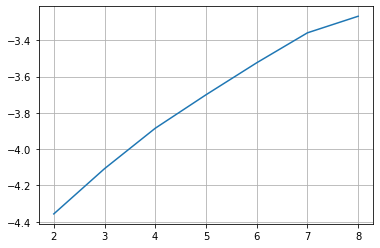

In [5]:
plt.plot(range(2,K+1),likelihoods)
plt.grid(True)

In [9]:
threshold = np.matrix(.01)
k = 2
Phi, Mu, Sigma = init_gmm(X, k)
# print(Phi)
# print(Mu)
# print(Sigma)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [10]:
print("======== Phi =========")
print(Phi)
print(phi_gt)
print("======== Mu =========")
print(Mu.T)
print(means_gt)
print("======== Sigma =========")
print(Sigma)
print(sigmas_gt)

======== Phi =========
[0.51795245 0.48204755]
[0.5, 0.5]
======== Mu =========
[[7.82106146 5.86056368]
 [1.54713133 3.99521618]]
[[2, 4], [8, 6]]
======== Sigma =========
[[[ 4.88117796 -1.24499242]
  [-1.24499242  5.13863863]]

 [[ 4.34808769 -1.73267309]
  [-1.73267309  6.24759797]]]
[matrix([[ 5, -2],
        [-2,  6]]), matrix([[ 5, -2],
        [-2,  6]])]


In [11]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]
print(outliers)

[  3   5   7  12  17  23  24  25  29  31  32  38  39  41  45  53  57  63
  68  69  71  74  78  80  85  97 103 104 108 115 117 131 138 139 141 144
 149 150 152 153 154 158 160 164 165 168 169 170 172 178 180 182 183 184
 185 192 193 197 199 202 204 206 208 209 210 212 221 222 235 238 240 241
 243 246 247 250 255 259 261 266 270 274 277 278 280 284 285 286 295 297
 301 305 310 317 321 322 324 330 335 342 347 350 353 355 359 365 374 377
 384 385 387 392 394 395 396]


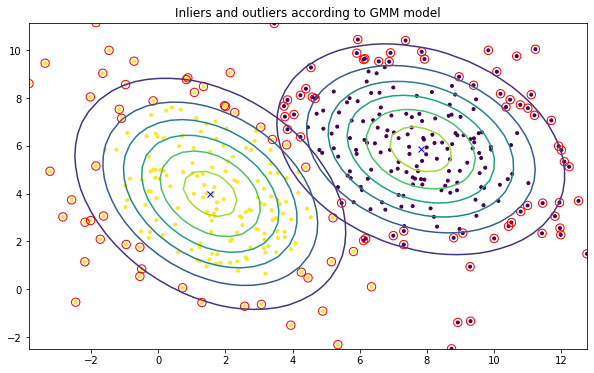

In [13]:
plt.figure(figsize=(10,6))
#c = pj: colors according to the probability of that particular point belong to that cluster
# c = X_label[:,2] or Z: colors according to cluster it belongs to
plt.scatter(X[:,0],X[:,1],marker=".",c=X_label[:,2],cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 30)
    ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 30)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)
plt.title('Inliers and outliers according to GMM model')
plt.show()

### KMEANS

In [15]:
def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k] #only the first k samples
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means


In [16]:
def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
#             print('dist j ',dist_j)
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
#                 print(j)
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

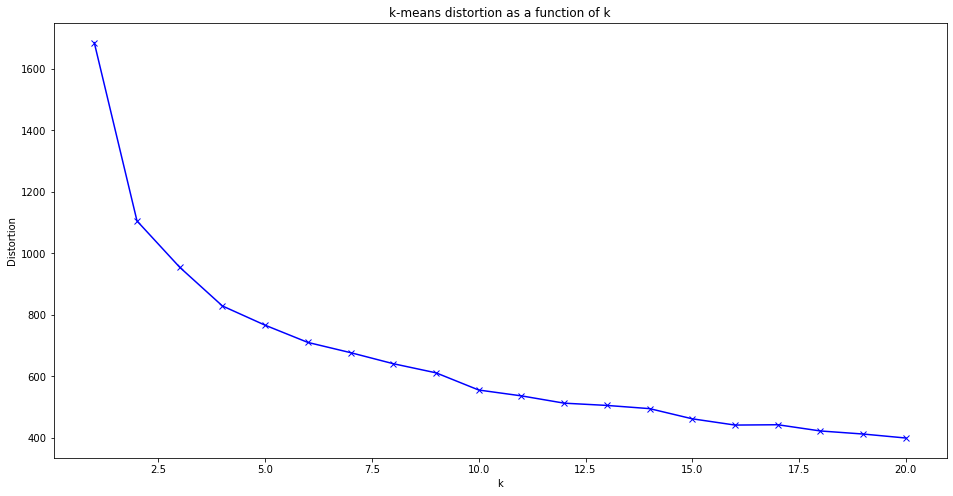

In [18]:
# Convert dataframe to matrix



# Intialize hyperparameters

max_k = 20
epsilon = 0.001

# For each value of k, do one run and record the resulting cost (Euclidean distortion)

distortions = np.zeros(max_k)
for k in range(1, max_k + 1):
    means = init_kmeans(X, k)
    prev_distortion = 0
    while True:
        means, c, distortion = iterate_kmeans(X, means)
#         print('c ',c)
        if prev_distortion > 0 and prev_distortion - distortion < epsilon:
            break
        prev_distortion = distortion
    distortions[k-1] = distortion
## WHAT IS c?
# Plot distortion as function of k

plt.figure(figsize=(16,8))  
plt.plot(range(1,max_k+1), distortions, 'bx-')
# plt.plot(range(1,max_k+1), distortion_k, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k-means distortion as a function of k')
plt.show()

# sudden increase, because of initialization ( initial cluster center is diffferent, its a cmpletely different arrangement not the existing cluster)

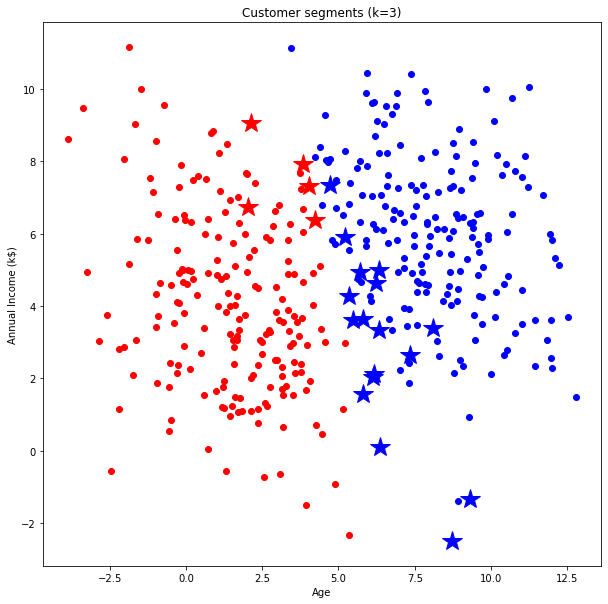

In [33]:
# Re-run k-means with k=3

k = 2
means = init_kmeans(X, k)
prev_distortion = 0
while True:
    means, c, distortion = iterate_kmeans(X, means)
    if prev_distortion > 0 and prev_distortion - distortion < epsilon:
        break
    prev_distortion = distortion
    
# Set labels in dataset to cluster IDs according to k-means model.

label = c

idx_correct = (label == 0) == (y == 0)
idx_correct_0 = ((label == 0) & idx_correct).reshape(400)
idx_correct_1 = ((label == 1) & idx_correct).reshape(400)
idx_incorrect_0 = ((label == 0) & ~idx_correct).reshape(400)
idx_incorrect_1 = ((label == 1) & ~idx_correct).reshape(400)

# Plot the data

fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='2d')
plt.plot(X[idx_correct_0, 0], X[idx_correct_0, 1], 'ro', label='Class 0 correct')
plt.plot(X[idx_correct_1, 0], X[idx_correct_1, 1], 'bo', label='Class 1 correct')
plt.plot(X[idx_incorrect_0, 0], X[idx_incorrect_0, 1], 'r*', label='Class 0 incorrect', ms=20)
plt.plot(X[idx_incorrect_1, 0], X[idx_incorrect_1, 1], 'b*', label='Class 1 incorrect', ms=20)
# ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
# ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)

# For 5 clusters, you can uncomment the following two lines.

#ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
#ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)

ax.view_init(0, 45)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.title('Customer segments (k=3)')
plt.show()